* Let us begin this task. We wll develop simple model. Beginner friendly code !!!! YAY !!!!
* Doing the necessary imports.
* We will be using Keras with Data Augementation
* Let us build model from scratch instead of Transfer Learning

In [1]:
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os,cv2
from IPython.display import Image
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
print(os.listdir("../input"))

Using TensorFlow backend.


['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
train_dir="../input/train/train"
test_dir="../input/test/test"
train=pd.read_csv('../input/train.csv')

df_test=pd.read_csv('../input/sample_submission.csv')
train.has_cactus=train.has_cactus.astype(str)

* Let us get a brief idea about the dataset that is given.
* We have total of 17500 cactii images here. 
* We have a medium sized data-set.
* * Looks like we have a biased data-set. We have has_cactus for more data equal to  1.
* This indicates that we have more images which have cactus.

In [3]:
train.tail()

,id,has_cactus
17495,ffede47a74e47a5930f81c0b6896479e.jpg,0
17496,ffef6382a50d23251d4bc05519c91037.jpg,1
17497,fff059ecc91b30be5745e8b81111dc7b.jpg,1
17498,fff43acb3b7a23edcc4ae937be2b7522.jpg,0
17499,fffd9e9b990eba07c836745d8aef1a3a.jpg,1


In [4]:
train['has_cactus'].value_counts()


1    13136
0     4364
Name: has_cactus, dtype: int64

## Reading the Images

* The main part is to handle the image data.
* We need to take input of the image file
* Decode the JPEG data into RGB channels
* Then normalize it by dividing by 255.
* We can do data-augmentation on top of that.

* We can rotate the images by certain angle. (Using rotation_range)
* We can also shift the images by a certain distance. (Using the width_shift_range and height_shift_range)
* We can also try to horizontally flip the images.
* I am not vertically flipping the image as it may mean an absurd view of aerial cactus.
* Also finally we are rescaling it by a factor of 1./255 to normalize the pixel values.

In [5]:
train_datagen = ImageDataGenerator(featurewise_center=False, samplewise_center=False, 
                             featurewise_std_normalization=False, 
                             samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, 
                             rotation_range= 55, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             brightness_range=None, 
                             shear_range=0.0, zoom_range=0.0, 
                             channel_shift_range=0.0, 
                             fill_mode='nearest',
                             cval=0.0, 
                             horizontal_flip=True, 
                             vertical_flip=False, 
                             rescale=1./255 , 
                             preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

* Note while validating.
* We do not want to check on augemented data.
* We avoid checking on that by creating new validation generator and making use of it directly.

In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)

* Usually use batch_sizes in multiples of 2.
* Fits well into the GPU

In [7]:
batch_size = 128

* Now we have to read the images with their labels which are in the train dataframe
* To do this Keras provides us the way of loading from dataframe using flow_from_dataframe
* Check it here https://keras.io/preprocessing/image/
* Also for a tutorial head here ->   https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1

* This also splits the data into two parts.
* We have 15000 images in train part.
* We have 2500 images in validation part.

In [8]:
train_generator = train_datagen.flow_from_dataframe(train[:15000], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(64, 64), color_mode='rgb', classes=None, 
                    class_mode='binary', batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 15000 validated image filenames belonging to 2 classes.


In [9]:
valid_generator = valid_datagen.flow_from_dataframe(train[15000:], directory=train_dir, x_col='id', y_col='has_cactus', 
                    target_size=(64, 64), color_mode='rgb', classes=None, 
                    class_mode='binary', batch_size=batch_size, 
                    shuffle=True, seed=None, 
                    save_to_dir=None, save_prefix='', save_format='png', 
                    subset=None, interpolation='nearest', drop_duplicates=True)

Found 2500 validated image filenames belonging to 2 classes.


## Making A CNN Model.

### How to make a CNN Model ?
Bulding a CNN is just like building our brain to recognize patterns. We try to focus only on certain featurs of image to understand that it is an aerial cactus. E.g seeing the green colour and spikes, considering its thickness might mean that we are seeing an aerial cactus.

So we need to reduce the feature maps that are given in the image. This is done by Conv2D layer. We glide the 3x3 kernel over the entire image of size 256 x 256 multiple times. Thus we are reducing the dimensions of image while learning about them.

We are thus making an abstract identification and description of an image.

Some points that made me think that we need this architecture: -

* Because we have very high number of images we need a deep model.
* We need connected layers of Conv2D. Which will extract features from a small 3x3 kernel.
* Also we need to increase the number of filters as we go deep to extract more features.
* We need to step-wize reduce the feature maps using MaxPooling operations.
* Since we are training a large number of parameters, we need to take care about overfitting.
* Also not to overfit we can include the Dropout layer. It has 0 parameters as well.
* Then we need to memorize a few attributes of Aerial Cactus. Sound odd but think about it. While learning patterns we also need a small amount of rote memory to recognize the pattern. So we need a densely connected layer as well.
* The activation function is relu in all Convulational layers.
* Since we want to predict the probabilities our last layer should be Softmax Layer.


In [10]:
model = Sequential()

In [11]:
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (64, 64, 3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 64, kernel_size= (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Dropout(0.3))


model.add(layers.Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 128, kernel_size= (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters = 256, kernel_size= (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(pool_size = (2,2), padding = 'same'))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))


* Let us have a quick summary of the model
* So there are 1,754,114 parameters to be tuned.
* Most of them come due to the fully connected layer.
* The model satisfies to our need, let us train this.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 128)       73856     
__________

* First we need to compile the model.
* Compiling the model has three parts, loss_function, optimizer and then the metrics.
* We want to minimize the binary_cross_entropy loss, since we are dealing with binary classification problem.
* Also we are using Adam optimizer.
* You could try different optimizer such as RMSProp or SGD also. 
* https://keras.io/optimizers/ for details of all optimizers available
* To learn more http://ruder.io/optimizing-gradient-descent/
* It is not required to tune Nadam hyper-parameters so we can ignore them as of now.
* We bother about accuracy score so we are using the metrics to be equalt to accuracy,

In [13]:
optim = Adam(lr=0.0022, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [14]:
model.compile(optimizer = optim, loss='binary_crossentropy', metrics=['accuracy'])

* Let us check point the model as well.
* We need only the best model, that is one which reduces the loss significantly or improves accuracy.
* We will store the weights of models in .hdf5 file.
* Then load this model and make predictions.

In [15]:
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
call_backs_list = [checkpoint]


In [16]:
max_epochs = 60
history = model.fit_generator(
    train_generator,
    steps_per_epoch = 100,
    epochs = max_epochs,
    validation_data = valid_generator,
    callbacks = call_backs_list,
    validation_steps = 50.
)

Epoch 1/60
100/100 [==============================] - 41s 407ms/step - loss: 0.3866 - acc: 0.8237 - val_loss: 0.2087 - val_acc: 0.9247

Epoch 00001: val_acc improved from -inf to 0.92468, saving model to best_model.hdf5
Epoch 2/60
100/100 [==============================] - 24s 239ms/step - loss: 0.1830 - acc: 0.9280 - val_loss: 0.1592 - val_acc: 0.9375

Epoch 00002: val_acc improved from 0.92468 to 0.93746, saving model to best_model.hdf5
Epoch 3/60
100/100 [==============================] - 23s 228ms/step - loss: 0.1537 - acc: 0.9394 - val_loss: 0.1301 - val_acc: 0.9473

Epoch 00003: val_acc improved from 0.93746 to 0.94729, saving model to best_model.hdf5
Epoch 4/60
100/100 [==============================] - 24s 240ms/step - loss: 0.1509 - acc: 0.9404 - val_loss: 0.1280 - val_acc: 0.9503

Epoch 00004: val_acc improved from 0.94729 to 0.95032, saving model to best_model.hdf5
Epoch 5/60
100/100 [==============================] - 24s 236ms/step - loss: 0.1370 - acc: 0.9462 - val_loss: 0

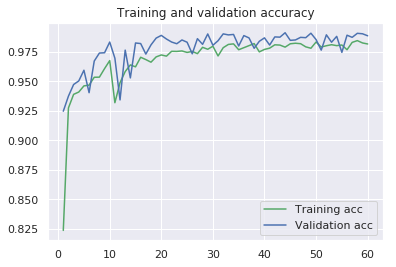

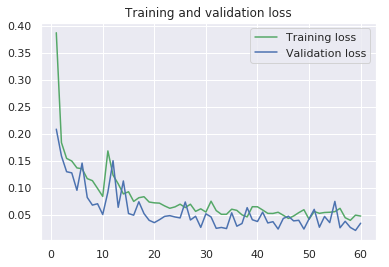

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

* Seems like after 50 our model does not learn much.
* We can try optimizing the learning rate, batch_size and also the epochs.
* Since we have checkpointed the model at point where validation accuracy is higher, the extra training after 50 does not matter.

In [18]:
model.load_weights("best_model.hdf5")

In [19]:
model.compile(optimizer = optim, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
un_test_img=[]
count=0
for i in os.listdir("../input/test/test/"):
    un_test_img.append(i)
    count+=1
un_test_image=[]
for i in tqdm(range(count)):
    img = image.load_img('../input/test/test/'+un_test_img[i], target_size=(64,64,3), grayscale=False)
    img = image.img_to_array(img)
    img = img/255
    un_test_image.append(img)
un_test_img_array = np.array(un_test_image)

100%|██████████| 4000/4000 [00:07<00:00, 523.75it/s]


In [21]:
len(un_test_img)

4000

In [22]:
output = model.predict_classes(un_test_img_array)

In [23]:
submission_save = pd.DataFrame()
submission_save['id'] = un_test_img
submission_save['has_cactus'] = output
submission_save.to_csv('submission.csv', header=True, index=False)

In [24]:
pd.read_csv('submission.csv')

,id,has_cactus
0,9cdda32671cb192f096b20c91b46a150.jpg,1
1,da498fc860c8b76ca925c4218c5f0373.jpg,1
2,433052030eeb117e4bd8f6ce033c9da4.jpg,1
3,4c76899a6e4b4a6cfdd2f28707fa8114.jpg,0
4,9efa3e92c1475b3ce4b7e2e598fa2785.jpg,1
5,873191a1575a6292ed92714bfc659b87.jpg,1
6,8f99b87b7a652d68232fbd6379529368.jpg,1
7,316e46903ee485aeecfd229973abcc71.jpg,0
8,fc76ae520f30c6aba6dbfa8e82def89c.jpg,1
9,ee3ddba5f04e0674db0d18a9dd3b8131.jpg,0
